In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import LinearSVR

In [3]:
data = pd.read_csv('train.csv')

Обработаем данные 

Заполним пропущенные значения этих переменных строкой None

In [7]:
data.Alley.fillna('None', inplace = True)
data.MasVnrType.fillna('None', inplace = True)
data.MasVnrArea.fillna(0.0, inplace = True)
data.BsmtQual.fillna('None', inplace = True)
data.BsmtCond.fillna('None', inplace = True)
data.GarageType.fillna('None', inplace = True)
data.BsmtExposure.fillna('None', inplace = True)
data.BsmtFinType1.fillna('None', inplace = True)
data.BsmtFinType2.fillna('None', inplace = True)
data.FireplaceQu.fillna('None', inplace = True)
data.GarageFinish.fillna('None', inplace = True)
data.GarageQual.fillna('None', inplace = True)
data.GarageCond.fillna('None', inplace = True)
data.PoolQC.fillna('None', inplace = True)
data.Fence.fillna('None', inplace = True)
data.MiscFeature.fillna('None', inplace = True)

Для этих параметров сделаем другую обработку

In [8]:
#Единственное пропущенное значение Electrical заменим на самое повторяющееся
data.Electrical.fillna('SBrkr', inplace = True)
#пропущенные значения LotFrontage заменим на среднее
data.LotFrontage.fillna(round(data.LotFrontage.mean(),0), inplace = True)
# Пропущенные значения GarageYrBlt заменим на значения YearBuilt, так как в большинстве других значений они равны
data.loc[data.GarageYrBlt.isnull(), 'GarageYrBlt'] = data.YearBuilt

Теперь для этих фичей сделаем LabelEncoding

In [10]:
Columns = ['MSZoning', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition', 'Electrical']

In [11]:
le = LabelEncoder()
for column in Columns:
    le.fit(data[column])
    data[column] = le.transform(data[column])

Подготовим данные 

In [12]:
x = data.copy()
x.drop(['Id', 'SalePrice'], axis=1, inplace=True)
y = data.SalePrice

Подготовим 10-fold разбиение

In [28]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(x)


10

обучим и оценим RFR на этом разбиении

In [44]:
res = []
for train_index, test_index in kf.split(y):
    model_RFR = RandomForestRegressor(n_estimators=10, max_depth=5, n_jobs=-1)
#    reg1 = StackingRegressor(estimators=estimators1, final_estimator=LinearRegression())
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_RFR.fit(x_train, y_train)
    res.append(model_RFR.score(x_test, y_test))
print(res)
RFR_score = np.mean(res)
print(f'Средний score модели: {np.mean(res)}')

[0.8112251192490578, 0.856899637081328, 0.8944307145605676, 0.7206457179517105, 0.8421718800791357, 0.8210702601476211, 0.8079892572974826, 0.8420833991093876, 0.6643124600604486, 0.8180041341595838]
Средний score модели: 0.8078832579696323


выведем важность признаков

<function matplotlib.pyplot.show(*args, **kw)>

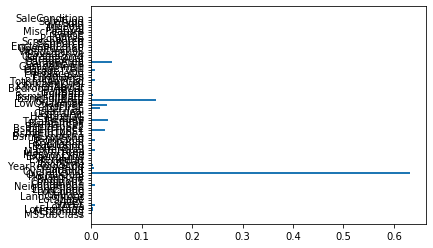

In [33]:
plt.barh(np.arange(len(model_RFR.feature_importances_)), model_RFR.feature_importances_)
plt.yticks(np.arange(len(x.columns)),x.columns)
plt.show

Обучиим стекинг, использовав  1 линейную модель и 1 нелинейную

Model 1

In [29]:
estimators1 = [('lr', LinearRegression()), 
              ('rfr', RandomForestRegressor(max_depth=5, 
                                            n_estimators=10, 
                                            criterion="mse", 
                                            random_state=42, 
                                            verbose=0, 
                                            n_jobs=-1
                                           ))
             ]

reg1 = StackingRegressor(estimators=estimators1,
                        final_estimator=LinearRegression()
                       )

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [45]:
reg1.fit(x_train, y_train)
Assemble1 = reg1.score(x_test, y_test)
print(Assemble1)

0.8216260023928571


Model 2

In [38]:
estimators2 = [('ridge', RidgeCV()), 
              ('dtr', DecisionTreeRegressor())
             ]

reg2 = StackingRegressor(estimators=estimators2,
                        final_estimator=RandomForestRegressor(max_depth=5, 
                                            n_estimators=10, 
                                            criterion="mse", 
                                            random_state=42, 
                                            verbose=0, 
                                            n_jobs=-1)
                       )

In [48]:
reg2.fit(x_train, y_train)
Assemble2 = reg2.score(x_test, y_test)
print(Assemle2)

0.8727342252218083


In [49]:
print(f'RFR score: {RFR_score}')
print(f'Assemble1 score: {Assemble1}')
print(f'Assemble2 score: {Assemble2}')

RFR score: 0.8078832579696323
Assemble1 score: 0.8216260023928571
Assemble2 score: 0.8682185884306346


применение ансаблей дает выигрышь в качестве модели